In [1]:
# Understanding autoencoders via a another example---> simple solid boxes in an image 
# This time I want to apply variational autoencoder (VAE )

In [31]:
# test


In [154]:


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import numpy as np

In [155]:
from utils.show_mesh import *
from utils.obj_file_toolkit import *
# show(filename)

In [156]:
filename = '/home/sobhan/Downloads/datasets/SPRING_FEMALE/mesh/SPRING0014.obj'

In [157]:
ver, nver,  fac = read_obj(filename)
ver.shape, nver.shape, fac.shape

((12500, 3), (12500, 3), (25000, 3))

In [158]:
from pathlib import Path
parent_folder = Path('/home/sobhan/Downloads/datasets/') 
female_folder = parent_folder / Path('SPRING_FEMALE/mesh')
male_folder   = parent_folder / Path('SPRING_MALE')

In [219]:

num_samples = 100 # threshold for filling our dataset
features  = torch.empty((num_samples, 12500, 3))

for idx, male_mesh in enumerate(male_folder.iterdir()):
    # show(str(male_mesh))
    ver, _, _ = read_obj(str(male_mesh))
    # print(np.max(ver))
    features[idx] = torch.tensor(ver)
    # print(torch.max(features[idx]))
    if idx+1 >= num_samples:
        break

In [220]:
features.shape

torch.Size([100, 12500, 3])

In [221]:
features[0].shape

torch.Size([12500, 3])

In [222]:
# box_siz = 24
# num_samples = 1000   # sample data number
# rand_radious= torch.randint(3, 150, (num_samples,))/10 # create a random array of raduis
# features = box(radius=rand_radious, box_size=box_siz)  # data set

In [223]:
features.shape

torch.Size([100, 12500, 3])

In [224]:
back_features = features
features[:,0] = (features[:,0] - torch.mean(features[:,0]))/torch.std(features[:,0])
features[:,1] = (features[:,1] - torch.mean(features[:,1]))/torch.std(features[:,1])
features[:,2] = (features[:,2] - torch.mean(features[:,2]))/torch.std(features[:,2])

In [225]:
# import pandas as pd
# _ = pd.DataFrame(features.reshape(-1,3).detach().numpy(), columns=["0","1","2"]).hist()
# _ = pd.DataFrame(back_features.reshape(-1,3).detach().numpy(), columns=["0","1","2"]).hist()


In [226]:
# output_file = 'point_cloud_'+time.strftime("%Y%m%d-%H%M%S")+'.xyz'
# np.savetxt(output_file, features.reshape(-1, 3).detach().numpy(), delimiter=' ')

In [227]:
# output_file = 'point_cloud_'+time.strftime("%Y%m%d-%H%M%S")+'.xyz'
# np.savetxt(output_file, back_features.reshape(-1, 3).detach().numpy(), delimiter=' ')

In [228]:
torch.flatten(features, start_dim=0)

tensor([ 0.4775,  0.8816, -1.3775,  ...,  0.0509,  0.0229, -0.1746])

In [229]:
features = torch.flatten(features, start_dim=1)

In [191]:
# import pandas as pd
# _ = pd.DataFrame(features.reshape(-1,3).detach().numpy()).hist()
# _ = pd.DataFrame(back_features.reshape(-1,3).detach().numpy(), columns=["0","1","2"]).hist()


In [230]:
features.shape

torch.Size([100, 37500])

In [231]:
features.numel()//num_samples

37500

In [232]:
batch_size = 40
# img_size = (32, 32) # (width, height)
# x_dim  = 784
# x_dim  = 784

input_dim = features.numel()//num_samples
# input_dim = 3

hidden_dim = 5000
latent_dim = 20


# input_dim = 3
# hidden_dim = 128
# n_embeddings= 768
output_dim = input_dim

lr = 2e-4

epochs = 300
DEVICE = 'cpu'
print_step = 50

In [194]:
from torch.utils import data

def load_array(data_arrays, batch_size, is_train=True): #@save
    """Construct a PyTorch data iterator."""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

In [195]:
# 80% for training and 20% for testing
train_x = features#[:-num_samples*80//100]
test_x  = features#[-num_samples*80//100:]

train_loader = load_array((train_x, train_x), batch_size)
# train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = load_array((test_x, test_x), 10)

In [196]:
train_x.shape, test_x.shape

(torch.Size([1, 37500]), torch.Size([1, 37500]))

In [197]:
"""
    A simple implementation of Gaussian MLP Encoder and Decoder
"""

class Encoder(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.FC_input = nn.Linear(input_dim, hidden_dim)
        self.FC_input2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_mean  = nn.Linear(hidden_dim, latent_dim)
        self.FC_var   = nn.Linear (hidden_dim, latent_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
        self.training = True
        
    def forward(self, x):
        h_       = self.LeakyReLU(self.FC_input(x))
        h_       = self.LeakyReLU(self.FC_input2(h_))
        mean     = self.FC_mean(h_)
        log_var  = self.FC_var(h_)                     # encoder produces mean and log of variance 
                                                       #             (i.e., parateters of simple tractable normal distribution "q"
        
        return mean, log_var

In [198]:

class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.FC_hidden = nn.Linear(latent_dim, hidden_dim)
        self.FC_hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_output = nn.Linear(hidden_dim, output_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        h     = self.LeakyReLU(self.FC_hidden(x))
        h     = self.LeakyReLU(self.FC_hidden2(h))
        
        x_hat = torch.sigmoid(self.FC_output(h))
        return x_hat

In [199]:
# This took me a while to understand it.
# z[i]= mu[i]+eps[i]*std[i]   for decoder 
# see bellow:

![image](VAE.jpg)

In [200]:
class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder
        
    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(DEVICE)        # sampling epsilon        
        z = mean + var*epsilon                          # reparameterization trick
        return z
        
                
    def forward(self, x):
        mean, log_var = self.Encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) # takes exponential function (log var -> var)
        x_hat            = self.Decoder(z)
        
        return x_hat, mean, log_var




In [201]:
encoder = Encoder(input_dim=input_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = output_dim)

model = Model(Encoder=encoder, Decoder=decoder).to(DEVICE)


In [202]:
# model(features[0].float())

# Defining loss function

In [203]:


from torch.optim import Adam

BCE_loss = nn.BCELoss()

def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat.float(), x.float(), reduction='sum')
    KLD      = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return torch.abs(reproduction_loss + KLD)


optimizer = Adam(model.parameters(), lr=lr)



# Training

In [206]:
print("Start training VAE...")
model.train()

for epoch in range(300):
    overall_loss = 0
    for batch_idx, (x, _) in enumerate(train_loader):
#         x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)

        optimizer.zero_grad()

        x_hat, mean, log_var = model(x.float())
        loss = loss_function(x, x_hat, mean, log_var)
        
        overall_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
    # print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / (batch_idx*batch_size))
    print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss )
    
print("Finish!!")


Start training VAE...
	Epoch 1 complete! 	Average Loss:  0.0
	Epoch 2 complete! 	Average Loss:  0.0
	Epoch 3 complete! 	Average Loss:  1.0


<ipython-input-206-1591c315d5d6>:13: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  loss = loss_function(x, x_hat, mean, log_var)//100


	Epoch 4 complete! 	Average Loss:  1.0
	Epoch 5 complete! 	Average Loss:  1.0
	Epoch 6 complete! 	Average Loss:  2.0
	Epoch 7 complete! 	Average Loss:  2.0
	Epoch 8 complete! 	Average Loss:  2.0
	Epoch 9 complete! 	Average Loss:  2.0
	Epoch 10 complete! 	Average Loss:  3.0
	Epoch 11 complete! 	Average Loss:  3.0
	Epoch 12 complete! 	Average Loss:  3.0
	Epoch 13 complete! 	Average Loss:  3.0
	Epoch 14 complete! 	Average Loss:  3.0
	Epoch 15 complete! 	Average Loss:  4.0
	Epoch 16 complete! 	Average Loss:  3.0
	Epoch 17 complete! 	Average Loss:  4.0
	Epoch 18 complete! 	Average Loss:  4.0
	Epoch 19 complete! 	Average Loss:  4.0
	Epoch 20 complete! 	Average Loss:  4.0
	Epoch 21 complete! 	Average Loss:  4.0
	Epoch 22 complete! 	Average Loss:  4.0
	Epoch 23 complete! 	Average Loss:  4.0
	Epoch 24 complete! 	Average Loss:  4.0
	Epoch 25 complete! 	Average Loss:  4.0
	Epoch 26 complete! 	Average Loss:  4.0
	Epoch 27 complete! 	Average Loss:  4.0
	Epoch 28 complete! 	Average Loss:  4.0
	Epoch

KeyboardInterrupt: 

In [207]:
import matplotlib.pyplot as plt
import numpy as np

In [208]:
# var.shape, y.shape, mu.shape

In [209]:
# mu

In [210]:

sample_example = 0
x = features[sample_example]#.reshape(-1,3).float()
y, mu, var = model(x)
# y = mu + y*var
y = y.reshape(-1,3)

In [211]:
# y = features[0].reshape(-1,3)

In [212]:
(features[:,0] - torch.mean(features[:,0]))/torch.std(features[:,0])

tensor([nan])

In [213]:

y[:, 0] = y[:,0]*torch.std(back_features[:,0]) + torch.mean(back_features[:,0])
y[:, 1] = y[:,1]*torch.std(back_features[:,1]) + torch.mean(back_features[:,1])
y[:, 2] = y[:,2]*torch.std(back_features[:,2]) + torch.mean(back_features[:,2])

In [214]:
# plt.subplot(211)
# plt.imshow(x.detach().numpy(), cmap='Greys')
# plt.subplot(212)
# plt.imshow(y.detach().numpy(), cmap='Greys',  interpolation='nearest')

In [74]:
import time

In [75]:
output_file = 'point_cloud_'+time.strftime("%Y%m%d-%H%M%S")+'.xyz'
np.savetxt(output_file, ver, delimiter=' ')


In [215]:
output_file = 'point_cloud_'+time.strftime("%Y%m%d-%H%M%S")+'.xyz'
np.savetxt(output_file, (y).detach().numpy(), delimiter=' ')

# Generate new samples

In [ ]:
# now taking decoder we can produce new data samples

In [218]:
batch_size

40

In [216]:
with torch.no_grad():
    noise = torch.randn(batch_size, latent_dim).to(DEVICE)
    generated_sample = decoder(noise)

In [217]:
output_file = 'point_cloud_'+time.strftime("%Y%m%d-%H%M%S")+'.xyz'
np.savetxt(output_file, generated_sample.detach().numpy(), delimiter=' ')

In [83]:
generated_sample

tensor([[0.4630, 0.5272, 0.4812,  ..., 0.4385, 0.4814, 0.4794],
        [0.4845, 0.4994, 0.4819,  ..., 0.4960, 0.4870, 0.4888],
        [0.4712, 0.5101, 0.5047,  ..., 0.4731, 0.4745, 0.4598],
        ...,
        [0.5064, 0.5310, 0.4811,  ..., 0.5183, 0.4504, 0.3963],
        [0.4912, 0.5714, 0.4627,  ..., 0.4268, 0.3851, 0.4603],
        [0.4584, 0.4842, 0.4602,  ..., 0.4917, 0.4606, 0.5198]])

In [79]:
generated_sample[0].shape

torch.Size([37500])

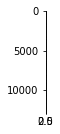

In [80]:
plt.subplot(212)
y = generated_sample[17].reshape(-1,3).float()
plt.imshow(y.detach().numpy(), cmap='Greys',  interpolation='nearest')

In [ ]:
plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=0.2)
plt.suptitle("Daily closing prices", fontsize=18, y=0.95)

# set number of columns (use 3 to demonstrate the change)
ncols =5
# calculate number of rows
nrows =batch_size//ncols
for idx, sample in enumerate (generated_sample):

    ax = plt.subplot(nrows, ncols, idx + 1)
    y = sample.reshape(box_siz//2 *2,box_siz//2 *2).float()

    plt.imshow(y.detach().numpy(), cmap='Greys',  interpolation='nearest')


# comment

In [ ]:
#  Based on what the programmer said in: 
#     https://github.com/Jackson-Kang/Pytorch-VAE-tutorial/blob/master/01_Variational_AutoEncoder.ipynb



Please note that this is not the correct generative process.

    Even if we don't know exact p(z|x), we can generate images from noise, since the loss function of training VAE regulates the q(z|x) (simple and tractable posteriors) must close enough to N(0, I). If q(z|x) is close to N(0, I) "enough"(but not tightly close due to posterior collapse problem), N(0, I) may replace the encoder of VAE.

    To show this, I just tested with a noise vector sampled from N(0, I) similar with Generative Adversarial Network.

